# Import data and libraries

## Import of data and libraries

### Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx

import time 
from tqdm import tqdm

from gensim.models import Word2Vec

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, auc, f1_score

In [20]:
# import functions from python files stored in utils directory 

import sys
sys.path.append('../utils')
from helper_functions import import_graph, generate_samples, deep_walk, edge_prediction
from feature_extractor import extract_graph_features, extract_node_features, get_relevant_node_features, get_combined_features

### Data

In [4]:
node_df = pd.read_csv("../data/node_information.csv", header=None)

In [5]:
print(node_df.shape)
node_df.head()

(3597, 933)


,0,1,2,3,4,5,6,7,8,9,...,923,924,925,926,927,928,929,930,931,932
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data exploration 

In [6]:
G  = import_graph("../data/train.txt")
print(nx.info(G))

Graph with 3597 nodes and 5248 edges


/var/folders/v2/_1kj2jc57736h6nlnncs10080000gn/T/ipykernel_92896/3100228866.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


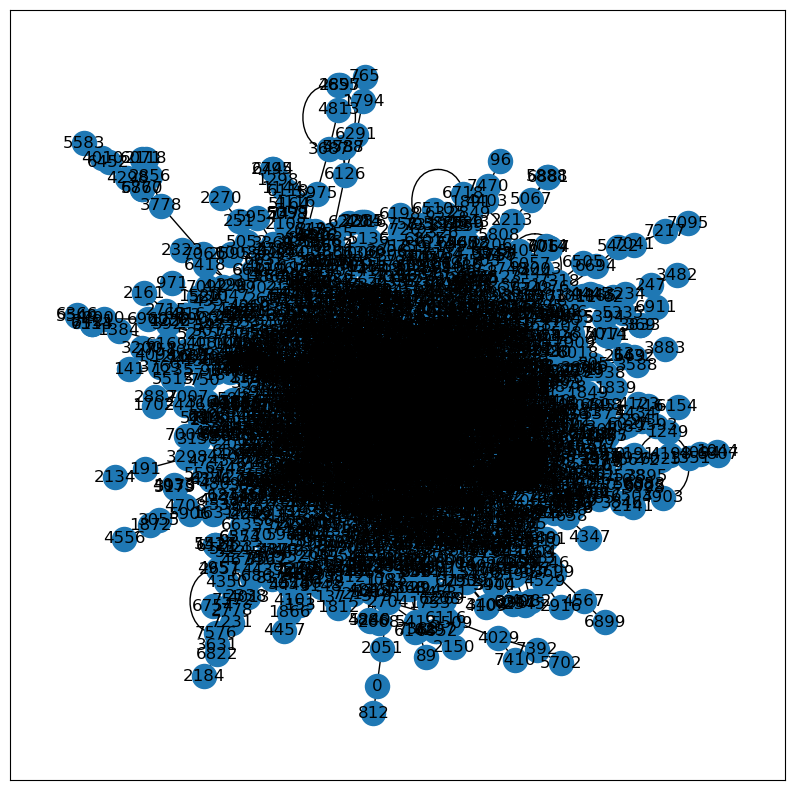

In [8]:
plt.figure(figsize =(10, 10))
nx.draw_networkx(G, with_labels = True)

## Exrtract relevant features from node information dataset 

In [7]:
node_df.head()

,0,1,2,3,4,5,6,7,8,9,...,923,924,925,926,927,928,929,930,931,932
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler



# Scale the features using min-max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(node_df)

# Create a PCA object with the desired number of components (e.g., 100)
pca = PCA(n_components=0.9)

# Fit the PCA object to the scaled data and transform the data to the reduced feature space
X_reduced = pca.fit_transform(X_scaled)


# Get the explained variance ratio for each principal component
explained_variances = pca.explained_variance_ratio_


# Create a new dataframe with the reduced feature space
data_reduced = pd.DataFrame(X_reduced)

In [9]:
# Get the explained variance ratio for each principal component
explained_variances = pca.explained_variance_ratio_

# Print the cumulative explained variance
print(f'Cumulative explained variance: {sum(explained_variances)}')

Cumulative explained variance: 0.9001774693031591


In [10]:
data_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
0,0.333491,-0.529530,-0.336107,0.436318,0.153754,0.251234,-0.482343,-0.861538,0.520748,0.376548,...,0.064039,0.048563,0.067780,-0.047697,0.026238,-0.007818,0.005432,0.041887,-0.084263,0.057968
1,-0.787217,-0.387460,0.105797,-0.088729,-0.089802,-0.196167,-0.479002,-0.071834,0.175633,0.211586,...,0.073663,-0.012140,0.007052,-0.074713,0.048514,-0.008852,-0.015700,-0.016746,0.062420,-0.050379
2,-0.682485,0.505441,0.160299,-0.129613,0.302025,0.111179,-0.431562,-0.290131,0.580281,-0.116185,...,0.004844,-0.002660,0.008200,0.007262,0.007705,-0.004389,-0.007859,-0.026583,0.000528,0.004331
3,0.587870,-0.560912,-0.477708,0.091449,0.048419,-0.086300,-0.489510,-0.199460,-0.111812,-0.147577,...,0.012111,0.028772,-0.015032,-0.031213,-0.029390,-0.015424,0.005971,-0.025909,-0.007464,-0.021752
4,-0.905921,0.579153,0.274450,0.468546,0.323029,-0.261011,-0.437969,0.145869,-0.385487,0.449230,...,-0.018420,-0.005393,0.010208,0.045675,0.016681,-0.039398,0.009272,-0.024950,0.034725,0.010002


# Baseline model

This baseline model does not include any node information. We only extract features from the graph, and perform the link prediction task. 

In [4]:
# Construct the training and testing sets
residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(graph=G, train_set_ratio=0.8)

In [ ]:
# Perform random walks over the residual network
num_of_walks, walk_length, window_size, embedding_size = (1000, 50, 15, 128)
residual_walks = deep_walk(graph=residual_g, N=num_of_walks, L=walk_length)
# Learn representations of nodes
model = Word2Vec(residual_walks, vector_size=embedding_size, sg=1, window=window_size, min_count=0, workers=3, hs=1, epochs=1, negative=0)

In [ ]:
# Train the classifier and perform the edge prediction and plot the ROC curve
edge_prediction(model.wv, train_samples, test_samples, train_labels, test_labels)

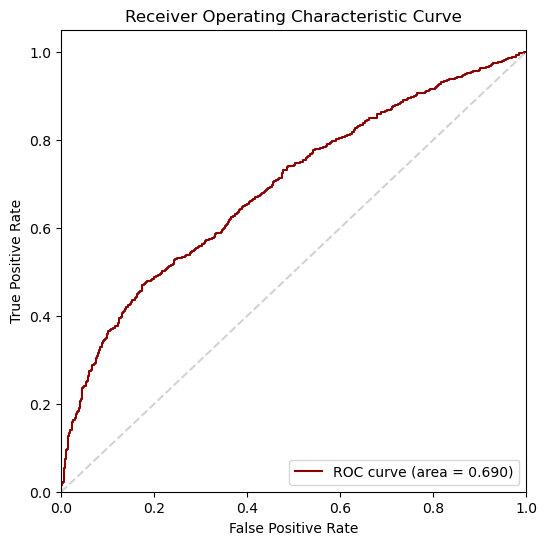

0.6901365956592188

In [11]:
# Perform random walks over the residual network
num_of_walks, walk_length, window_size, embedding_size = (500, 10, 5, 32)
residual_walks = deep_walk(graph=residual_g, N=num_of_walks, L=walk_length)
# Learn representations of nodes
model = Word2Vec(residual_walks, vector_size=embedding_size, sg=1, window=window_size, min_count=0, workers=3, hs=1, epochs=1, negative=0)
# Train the classifier and perform the edge prediction and plot the ROC curve
edge_prediction(model.wv, train_samples, test_samples, train_labels, test_labels)

# Model 1 : Random Forest

For this first model, we will extract feature from both the graph, and node inforamtion dataset. Then , we will train a Random Forest on these features, and fine-tune the hyperparameters. 

## Feature engineering 

In [12]:
# Import datasets
train_df = pd.read_csv('../data/train.txt', sep=' ', header=None, names=['source', 'target', 'label'])
test_df = pd.read_csv('../data/test.txt', sep=' ', header=None, names=['source', 'target'])
node_info_df = pd.read_csv('../data/node_information.csv', header=None)

In [13]:
from node2vec import Node2Vec


# Generate walks
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/3597 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


In [14]:
edge_features_train = extract_graph_features(model, train_df)
print(f"The size of edge features of the trainig set is : {edge_features_train.shape}")

The size of edge features of the trainig set is : (10496, 128)


In [15]:
edge_features_test = extract_graph_features(model, test_df)
print(f"The size of edge features of the trainig set is : {edge_features_test.shape}")

The size of edge features of the trainig set is : (3498, 128)


In [27]:
## Reduce the dimension of the node information dataset 

X_node_reduced_df = get_relevant_node_features(node_info_df, n_components=128)

In [28]:
## Extract all combined features for the trainig set 

X, labels = get_combined_features(X_node_reduced_df, edge_features_train, train_df, is_train_dataset=True)

100%|████████████████████████████████████| 10496/10496 [00:10<00:00, 994.73it/s]


In [29]:
## Extract all combined features for the test set 

X_test, _ = get_combined_features(X_node_reduced_df, edge_features_test, test_df, is_train_dataset=False)

100%|█████████████████████████████████████| 3498/3498 [00:01<00:00, 1821.18it/s]


## Model selection

In [16]:
# SELECTION OF THE BEST PARAMETERS

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]

max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

In [ ]:
import warnings

## Takes a lot of time !!!

# run block of code and catch warnings
with warnings.catch_warnings():
 # ignore all caught warnings
    warnings.filterwarnings("ignore")
     # execute code that will generate warnings
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()

    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X, labels)

In [50]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

## Validation of the model

In [30]:
rf = RandomForestClassifier(n_estimators=2000,
 min_samples_split= 2,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= 60,
 bootstrap= False)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

/Users/anouaroussalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/var/folders/v2/_1kj2jc57736h6nlnncs10080000gn/T/ipykernel_92896/2607646714.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
/Users/anouaroussalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [32]:
print(f"The accuracy on the validation set is {round(accuracy_score(y_val, y_pred),4)}")

The accuracy on the validation set is 0.9381


In [33]:
print(f"The f1-score on the validation set is {round(f1_score(y_val, y_pred),4)}")

The f1-score on the validation set is 0.9365


## Classification of the test set 

In [34]:
# Classify the test set 


rf = RandomForestClassifier(n_estimators=2000,
 min_samples_split= 2,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= 60,
 bootstrap= False)

# we train the model on the whole training set 
rf.fit(X, labels)

/Users/anouaroussalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/var/folders/v2/_1kj2jc57736h6nlnncs10080000gn/T/ipykernel_92896/2272166155.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X, labels)


RandomForestClassifier(bootstrap=False, max_depth=60, max_features='sqrt',
                       n_estimators=2000)

In [35]:
y_pred = rf.predict(X_test)

/Users/anouaroussalah/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [36]:
## Write the submission
import csv

nb_submission = 1


# Load test samples 
with open("../data/test.txt", "r") as f:
    reader = csv.reader(f)
    test_set = list(reader)
test_set = [element[0].split(" ") for element in test_set]

# Make random predictions

predictions = zip(np.array(range(len(test_set))), y_pred)

# note: Kaggle requires that you add "ID" and "category" column headers

with open(f"../data/submission_{nb_submission}.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in predictions:
         csv_out.writerow(row)
    pred.close()

### XGBoost

In [75]:
from xgboost import XGBClassifier

X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)

model = XGBClassifier(scale_pos_weight=1,
                      learning_rate=0.1,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=7, 
                      gamma=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(f"The accuracy on the validation set is {round(accuracy_score(y_val, y_pred),4)}")
print(f"The f1-score on the validation set is {round(f1_score(y_val, y_pred),4)}")

The accuracy on the validation set is 0.99
The f1-score on the validation set is 0.99


In [72]:
y_pred = model.predict(X_test)

In [73]:
import csv

nb_submission = 2


# Load test samples 
with open("../data/test.txt", "r") as f:
    reader = csv.reader(f)
    test_set = list(reader)
test_set = [element[0].split(" ") for element in test_set]

# Make random predictions

predictions = zip(np.array(range(len(test_set))), y_pred)

# note: Kaggle requires that you add "ID" and "category" column headers

with open(f"../data/submission_{nb_submission}.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in predictions:
         csv_out.writerow(row)
    pred.close()